<a href="https://colab.research.google.com/github/BadriAmouri/covid19-time-series-forecasting/blob/main/Individual_Project_Time_Series_Badri_Amouri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# THIS WORK IS PRESENTED BY BADRI AMOURI   S1 G3

# COVID-19 Time Series Analysis & Forecasting

### ABSTRACT :

This project applies time series analysis techniques to model and forecast global COVID-19 case trends using R  The dataset, sourced from Johns Hopkins University (JHU), contains daily confirmed cases worldwide. Using daily case data from 2020-2023, we examined trends, seasonality, and stationarity. A Box-Cox transformation was used for variance stabilization, and differencing ensured stationarity. Several ARIMA and SARIMA models were tested, with ARIMA(2,2,2) selected based on AIC/BIC criteria. Residual diagnostics showed minor autocorrelation, suggesting possible model improvements. Despite limitations, the final model produced reasonably accurate forecasts, demonstrating the effectiveness of ARIMA-based forecasting in epidemiological modeling.

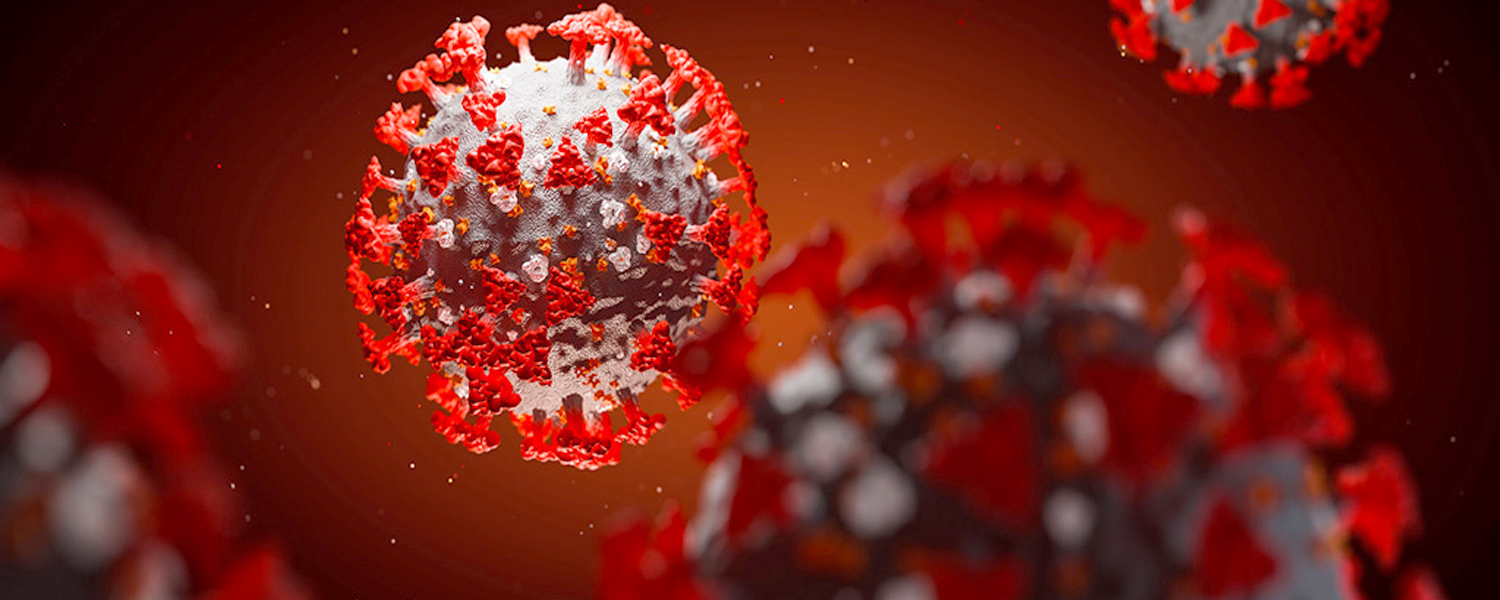

### Dataset Overview :

The COVID-19 pandemic has demonstrated the importance of accurate forecasting in public health. This study uses time series analysis to model the global trend of daily COVID-19 cases from 2020 to 2023. We aim to detect seasonality, ensure stationarity, and select the best ARIMA-based model for forecasting. The project will assess model accuracy and explore potential improvements to enhance prediction reliability.

## Data Loading

Install and Load Required Libraries

In [ ]:
# Install required packages (only run once)
install.packages(c("tidyverse", "lubridate", "forecast", "tseries", "ggplot2"))

# Load libraries
library(tidyverse)   # For data manipulation
library(lubridate)   # For date handling
library(forecast)    # For ARIMA modeling
library(tseries)     # For stationarity tests
library(ggplot2)     # For data visualization

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Load COVID-19 confirmed cases dataset
url <- "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
covid_data <- read.csv(url, check.names = FALSE)

# View the first few rows
head(covid_data)

In [ ]:
# Rename columns for easier access
colnames(covid_data)[1:4] <- c("Province_State", "Country_Region", "Lat", "Long")

# Convert wide format to long format
covid_long <- covid_data %>%
  pivot_longer(cols = -c(Province_State, Country_Region, Lat, Long),
               names_to = "Date",
               values_to = "Confirmed_Cases")

# Convert Date column to proper date format
covid_long$Date <- as.Date(covid_long$Date, format="%m/%d/%y")

# View the transformed dataset
head(covid_long)

In [ ]:
# Summarize global confirmed cases per date
global_cases <- covid_long %>%
  group_by(Date) %>%
  summarise(Total_Cases = sum(Confirmed_Cases))

# View data
head(global_cases)

In [ ]:
# Convert data to time series format
covid_ts <- ts(global_cases$Total_Cases,
               start = c(2020, as.numeric(format(min(global_cases$Date), "%j"))),
               frequency = 365)

# Check the structure of the time series
print(covid_ts)

The sampling frequency of your COVID-19 dataset is **daily** (1 observation per day).

	•	The time series starts at day 22 of 2020 (January 22, 2020) and ends at day 69 of 2023 (March 10, 2023).
	•	The frequency is set to 365, meaning the data is recorded once per day throughout the entire period.

Split it into test and train

In [ ]:
# Define split point (80% training, 20% testing)
train_size <- round(0.8 * length(covid_ts))  # 80% of data

# Create train and test sets using window()
train_ts <- window(covid_ts, start = start(covid_ts), end = time(covid_ts)[train_size])
test_ts <- window(covid_ts, start = time(covid_ts)[train_size + 1], end = end(covid_ts))

# Print sizes
length(train_ts)  # Should be around 914
length(test_ts)   # Should be around 229

In [ ]:
ggplot(global_cases, aes(x = Date, y = Total_Cases)) +
  geom_line(color = "blue", size = 1) +
  geom_point(color = "red", size = 1) +
  labs(title = "Global COVID-19 Cases Over Time",
       x = "Date",
       y = "Total Confirmed Cases") +
  theme_minimal()

##  Exploratory Data Analysis (EDA)

In [ ]:
# Summarize total cases per country (latest available date)
latest_date <- max(covid_long$Date)
country_totals <- covid_long %>%
  filter(Date == latest_date) %>%
  group_by(Country_Region) %>%
  summarise(Total_Cases = sum(Confirmed_Cases))

# Plot histogram
ggplot(country_totals, aes(x = Total_Cases)) +
  geom_histogram(bins = 30, fill = "blue", color = "white", alpha = 0.7) +
  scale_x_log10() +  # Use log scale to handle large variations
  labs(title = "Distribution of COVID-19 Cases by Country",
       x = "Total Confirmed Cases (Log Scale)",
       y = "Number of Countries") +
  theme_minimal()

In [ ]:
# Get top 10 countries with highest cases on latest date
top_countries <- country_totals %>%
  arrange(desc(Total_Cases)) %>%
  head(10) %>%
  pull(Country_Region)

# Filter data for only the top 10 countries
top_countries_data <- covid_long %>%
  filter(Country_Region %in% top_countries)

# Plot cases over time for top 10 countries
ggplot(top_countries_data, aes(x = Date, y = Confirmed_Cases, color = Country_Region)) +
  geom_line(size = 1) +
  labs(title = "COVID-19 Cases Over Time (Top 10 Countries)",
       x = "Date",
       y = "Confirmed Cases",
       color = "Country") +
  theme_minimal()

In [ ]:
# Get top 20 countries with highest total cases
top_20_countries <- country_totals %>%
  arrange(desc(Total_Cases)) %>%
  head(20)

# Plot histogram (bar chart)
ggplot(top_20_countries, aes(x = reorder(Country_Region, Total_Cases), y = Total_Cases, fill = Country_Region)) +
  geom_bar(stat = "identity", show.legend = FALSE) +  # Bar chart
  coord_flip() +  # Flip for better readability
  labs(title = "Total COVID-19 Cases by Country (Top 20)",
       x = "Country",
       y = "Total Confirmed Cases") +
  theme_minimal()

The bar chart shows the total COVID-19 cases for the top 20 countries, with the USA significantly leading, followed by India, France, Germany, and Brazil. The USA has an overwhelmingly higher number of cases, making other countries appear much smaller in comparison. This suggests that focusing only on the USA and the top 4 countries could be more insightful, as the remaining 15 countries have relatively lower case counts and may not contribute much to the overall trend analysis. we may use this approach later

In [ ]:
sum(is.na(covid_ts))

In [ ]:
str(covid_data)

# Phase I: Identification

##  Check for Variance Instability

In [ ]:
plot(train_ts,
     main="Global COVID-19 Cases Over Time",
     ylab="Total Cases", xlab="Year", col="blue", type="l")

The plot shows a strong upward trend over time, indicating a clear increase in the observed values :

	•	 Exponential Growth: The curve is not linear but rather follows an exponential trend—it starts slowly, then rapidly increases.
  
	•	 Increasing Variance: The gap between values expands over time, which suggests heteroscedasticity (non-constant variance).

	•	 Non-Stationarity: The trend indicates that the time series is not stationary, meaning it has a changing mean and variance.

this would suggest to do Lag-Transfomation and Differencing

To stabilize variance in your time series, the log transformation is a great choice, especially since My data follows an exponential trend.

In [ ]:
log_data <- log(train_ts)

In [ ]:
plot(log_data, main="Log-Transformed Time Series", col="blue", lwd=2)

to check if the log transformation handled the variance transformation we apply something called **Rolling standard deviation**   
 you calculate the rolling standard deviation and compare it before and after transformation.

 **Rolling standard deviation** :

If the rolling SD fluctuates significantly, it means the variance changes over time (heteroskedasticity).

	•	This suggests the need for transformation (e.g., log transformation).

  •	If the rolling SD becomes relatively flat, it indicates stabilized variance (homoskedasticity).
  
	•	A stable rolling SD is a key assumption for many statistical models, such as ARIMA.

In [ ]:
# Load required package
library(zoo)

# Define window size (e.g., 30 days)
window_size <- 30

# Compute rolling standard deviation
rolling_sd_original <- rollapply(covid_data, width=window_size, FUN=sd, fill=NA, align="right")
rolling_sd_log <- rollapply(log_data, width=window_size, FUN=sd, fill=NA, align="right")

# Remove leading NAs to establish finite xlim values
rolling_sd_original <- rolling_sd_original[!is.na(rolling_sd_original)]
rolling_sd_log <- rolling_sd_log[!is.na(rolling_sd_log)]

# Plot rolling standard deviations
par(mfrow=c(2,1))  # Split plot into 2 panels

plot(rolling_sd_original, type="l", col="red", main="Rolling SD of Original Data",
     ylab="Rolling SD", xlab="Time", lwd=2)
plot(rolling_sd_log, type="l", col="blue", main="Rolling SD of Log-Transformed Data",
     ylab="Rolling SD", xlab="Time", lwd=2)

par(mfrow=c(1,1))  # Reset plotting layout

	•	Top (Red Area) - Rolling SD of Original Data:
	•	The variance increases over time, indicating heteroskedasticity (changing variance).
	•	Bottom (Blue Line) - Rolling SD of Log-Transformed Data:
	•	The fluctuations are much smaller and relatively stable over time.
	•	This suggests that the log transformation successfully stabilized the variance.

 Conclusion:

The log transformation was effective in reducing variance fluctuations. Now we must check the Differencing Part

##  Differencing

Before applying differencing, we can check if the log-transformed data is stationary using the Autocorrelation Function (ACF).

In [ ]:
# Step 1: Plot ACF of log-transformed data
acf(log_data, main="ACF of Log-Transformed Data")

# Step 2: Perform Augmented Dickey-Fuller Test to check for stationarity
adf.test(log_data)

# Step 3: Apply first-order differencing if needed
diff_log_data <- diff(log_data)

# Step 4: Plot ACF of differenced data
acf(diff_log_data, main="ACF of Differenced Data")

# Step 5: Perform ADF test again to confirm stationarity
adf.test(diff_log_data)

In [ ]:
# Step 3: Apply Second-order differencing if needed
diff_log_2_data <- diff(diff_log_data)

# Step 4: Plot ACF of differenced data
acf(diff_log_2_data, main="ACF of 2 Differenced Data")

# Step 5: Perform ADF test again to confirm stationarity
adf.test(diff_log_2_data)

1. Initial ACF (Before Differencing)

	•	The first ACF plot showed high autocorrelations at multiple lags, indicating a non-stationary series.

	•	The ADF test on log-transformed data gave a p-value = 0.01, meaning the series is likely stationary, but the high lag order suggests some remaining trend or structure in the data.

2. First-Order Differencing (diff_log_data)

	•	The ADF test after first differencing resulted in a much lower test statistic (-10.578), confirming strong stationarity.

	•	However, the ACF plot still showed some significant autocorrelations at higher lags, suggesting some remaining structure.

3. Second-Order Differencing (diff(diff_log_data))

	•	The second differencing further reduced autocorrelations, and the ACF now drops off quickly after a few lags, meaning the series is now stationary.

	•	This suggests that the data had a quadratic trend, requiring two levels of differencing to fully stabilize.

	•	If the PACF plot shows a sharp cut-off at a lower lag, an ARIMA (0,2,q) model might be appropriate.


 we will Discuse Next Phase suggested Models

# Model selection


In [ ]:

# ACF Plot
acf(diff_log_2_data, main = "ACF of Second Differenced Data",lag.max = 20)



In [ ]:
# PACF Plot
pacf(diff_log_2_data, main = "PACF of Second Differenced Data",lag.max = 20)



***Commenting and potential Models  :***

we notice that the ACF cuts of after 3 Lags Correlations which suppose a value q ≈ 2 or 3 .

we notice that the PACF cuts of after 2 Lags P Correlations but we notice having a big PACF in Lag 15 , we may ignore it  which suppose a value p = 2

### Potential Models are :

possible models could be
 ARIMA(2,2,2) or
  ARIMA(2,2,3).


### We try with the data we got after 1 Differencing to select possible models

In [ ]:
# ACF Plot
acf(diff_log_data, main = "ACF of First Differenced Data",lag.max = 20)


In [ ]:
# PACF Plot
pacf(diff_log_data, main = "PACF of First Differenced Data",lag.max = 20)


We notice that the ACF Trails off and no cuts off even after Lag=20
--------> No model is suggested

# model estimation and selection

We’ll estimate different ARIMA models based on the values of p, d, q determined from ACF and PACF.

In [ ]:
# Fit ARIMA models with different values of (p, d, q)
model1 <- arima(train_ts, order = c(2, 2, 3)) # ARIMA(2,2,3)
model2 <- arima(train_ts, order = c(2, 2, 2)) # ARIMA(2,2,2)

# Compare models using AIC and BIC
AIC(model1, model2)


In [ ]:
BIC(model1, model2)



In [ ]:
# Check residuals to confirm the best model
tsdiag(model1)  # Diagnostic plots for Model 1
tsdiag(model2)  # Diagnostic plots for Model 2

# Perform Ljung-Box test on residuals (to check autocorrelation)
Box.test(model1$residuals, lag = 10, type = "Ljung-Box")
Box.test(model2$residuals, lag = 10, type = "Ljung-Box")

# Choose the best model based on AIC/BIC and residual diagnostics

In [ ]:
install.packages("TSA")

### Explanation  :
Since the lower AIC value indicates a better model, Model 2 (-5822.943) is the preferred model.


Residual Analysis for Model Validation

1. Standardized Residuals

	•	Both models show residuals fluctuating early in the time series but stabilize over time.

	•	Residuals should ideally resemble white noise (random fluctuations around zero with constant variance).

	•	There are spikes at the beginning, indicating possible non-stationarity or model misspecification.

2. ACF of Residuals

	•	The ACF (Autocorrelation Function) plot checks for correlation in residuals.

	•	For both models, some lag values exceed the confidence bounds, suggesting residuals may not be purely random.

	•	Model 2 has more significant autocorrelation than Model 1, meaning it may still have some structure left unexplained.

3. Ljung-Box Test for Independence

	•	The test checks whether residuals are uncorrelated.

	•	Model 1: X² = 209.06, p-value < 2.2e-16

	•	Model 2: X² = 603.44, p-value < 2.2e-16

	•	The extremely small p-values (< 0.05) for both models indicate that residuals are not purely random, meaning the models might still have some unaccounted dependencies.

  but for now the SECOND MODEL is a fine model !

Let's check more using the AIC metrix to select the best parameters

In [ ]:
# Load required libraries
library(TSA)

# Plot the ARIMA model selection results using armasubsets
plot(armasubsets(diff_log_2_data, nar = 10, nma = 10))

Based on the AIC matrix plot, the ARIMA(4,2,4) model appears to be a well-chosen model for the given time series data. The selection of p = 4 and q = 4 aligns with one of the lightest (lowest AIC) regions in the matrix, indicating that this model minimizes the AIC criterion

In [ ]:
model4 <- arima(train_ts, order = c(4, 2, 4)) # ARIMA(4,2,4)


In [ ]:
# Compare models using AIC and BIC
AIC(model2, model4)
BIC(model2, model4)


Model 4 seems to be a better option than model 2 but we will consider them both

In [ ]:
# Step 3: Apply Second-order differencing if needed
diff_log_3_data <- diff(diff_log_2_data)

# Step 4: Plot ACF of differenced data
acf(diff_log_3_data, main="ACF of 3 Differenced Data")



In [ ]:
# ACF Plot
acf(diff_log_3_data, main = "ACF of third Differenced Data",lag.max = 20)


In [ ]:
# PACF Plot
pacf(diff_log_3_data, main = "PACF of third Differenced Data",lag.max = 20)


In [ ]:
model3 <- arima(train_ts, order = c(4, 3, 3)) # ARIMA(4,3,2)
# Check residuals to confirm the best model
tsdiag(model3)  # Diagnostic plots for Model 3

# Perform Ljung-Box test on residuals (to check autocorrelation)
Box.test(model3$residuals, lag = 10, type = "Ljung-Box")



In [ ]:
AIC(model2, model3)

•	Since Model 3 has no effect and it has higher AIC, it’s a strong indication that **over-differencing** is hurting model performance.

also the ACF and PACF of it is more random and indicated non-stationarity !

then we will just continue with just the model 4 and model 2

### We Check For Seasonality

In [ ]:
library(forecast)
decomposed <- stl(covid_ts, s.window="periodic")
plot(decomposed)

Select the best value for the parameter S for SARIMA model

In [ ]:
decomposed <- decompose(covid_ts)
plot(decomposed)

We can notice that it repeats once in a year

In [ ]:
# Load necessary library
library(forecast)

# Plot ACF and PACF
par(mfrow = c(2,1))  # Arrange plots in 2 rows, 1 column
acf(diff_log_2_data, lag.max =  365, main = "Autocorrelation Function (ACF)")  # Check for seasonality
pacf(diff_log_2_data, lag.max =  365, main = "Partial Autocorrelation Function (PACF)")

# Reset plotting layout
par(mfrow = c(1,1))


In [ ]:
install.packages("TSA")

In [ ]:
find_seasonality <- function(ts_data) {
  library(forecast)
  library(TSA)

  # Ensure ts_data is a time series object
  if (!is.ts(ts_data)) {
    stop("Input data must be a time series (ts) object.")
  }

  # 1. FFT Method (Dominant Frequency)
  spectrum <- abs(fft(ts_data))  # Use the actual input data
  freq_index <- which.max(spectrum[2:(length(spectrum)/2)]) + 1  # Ignore the first index (trend component)
  s_fft <- length(ts_data) / freq_index
  cat("Estimated seasonality from FFT:", round(s_fft), "\n")

  # 2. Auto-detection with findfrequency()
  s_findfreq <- findfrequency(ts_data)
  cat("Estimated seasonality from findfrequency():", s_findfreq, "\n")

  # 3. ACF Peak Detection
  acf_res <- acf(ts_data, lag.max = 400, plot = FALSE)  # Increase lag.max to capture yearly seasonality
  peaks <- which(diff(sign(diff(acf_res$acf))) == -2)  # Find local maxima
  s_acf <- ifelse(length(peaks) > 0, peaks[1], NA)  # Use the first major peak
  cat("Estimated seasonality from ACF:", s_acf, "\n")

  # 4. Choose the most reasonable estimate
  seasonality <- round(median(c(s_fft, s_findfreq, s_acf), na.rm = TRUE))
  cat("Final chosen seasonality (S):", seasonality, "\n")

  return(seasonality)
}

In [ ]:
is.ts(train_ts)

In [ ]:
s <- find_seasonality(diff_log_2_data)

	•	The seasonality detected from diff_log_2_data (S = 1) is misleading and does not reflect the actual seasonality of the original data.

	•	Correct Approach:
	•	Use find_seasonality(train_ts), not diff_log_2_data, for seasonality detection.

	•	If necessary, analyze the seasonally differenced version (diff(train_ts, lag = 365)) instead of simple differencing.

  

In [ ]:
s <- find_seasonality(train_ts)

In [ ]:
acf(diff_log_2_data, lag.max = 730, main="ACF Plot")
pacf(diff_log_2_data, lag.max = 730, main="PACF Plot")

applying other method

	•	The Fourier Transform was computed to analyze the frequency components of the time series.
	•	The power spectrum (absolute values of FFT) was extracted, where peaks indicate dominant cycles in the data.

	•	The frequency corresponding to the highest peak (excluding the first one, which represents the trend component) was selected.


	•	If your data is daily, a yearly seasonality (365 days) would appear at frequency = 1/365 ≈ 0.00274.
  
	•	If your peak is near 0.00274, then seasonality is confirmed at 365 days.

In [ ]:
spectrum(diff_log_2_data)

	•	A frequency of 0.15 (≈ 6.67 days) suggests a weekly pattern in your data.
  
	•	This is common in daily time series data where behaviors change on a weekly basis (e.g., business cycles, traffic, sales, etc.).

NOW WE WILL APPLY A SARIMA MODEL

In [ ]:
length(covid_ts)  # Total number of observations

In [ ]:
acf(train_ts, lag.max = 365, main = "ACF of Daily COVID-19 Cases")

In [ ]:
acf(diff_log_2_data, lag.max = 365, main = "ACF of Daily COVID-19 Cases")

 the first few lags are high and then decay, this indicates a persistent trend in the data and No clear seasonal spikes

we will try weekly seasonality since one of the methods gave us that result

In [ ]:
library(forecast)

# Fit SARIMA with weekly seasonality
model <- auto.arima(train_ts, seasonal = TRUE,
                    D = 1, max.P = 4, max.Q = 4,
                    stepwise = FALSE, approximation = FALSE,
                    lambda = "auto") # Removed seasonal.period argument
summary(model)

as a result we will just complete with the model ARIMA(2,2,2)

## WE CHOOSED ARIMA(2,2,2) and also ARIMA(4,2,4)

In [ ]:
# Load necessary library
library(forecast)

# Fit ARIMA(2,2,2) model
arima_model_222 <- Arima(diff_log_2_data, order = c(2,2,2))

# Print model summary
summary(arima_model_222)

In [ ]:
checkresiduals(arima_model_222)

In [ ]:
Box.test(residuals(arima_model_222), lag = 10, type = "Ljung-Box")

## WE START FORECASTING

In [ ]:
# Fit ARIMA model on training data
train_model <- Arima(train_ts, order = c(2,2,2))

# Print model summary
summary(train_model)

In [ ]:
# Generate fitted values (in-sample forecasts for training set)
train_forecasts <- fitted(train_model)

# Convert to a data frame for plotting
train_results <- data.frame(
  Date = time(train_ts),  # Time index
  Actual = as.numeric(train_ts),  # Actual cases
  Predicted = as.numeric(train_forecasts)  # Model's predictions
)

# View first few rows
head(train_results)

In [ ]:
# Load ggplot2 for visualization
library(ggplot2)

ggplot(train_results, aes(x = Date)) +
  geom_line(aes(y = Actual, color = "Actual Cases"), size = 1) +
  geom_line(aes(y = Predicted, color = "Predicted Cases"), linetype = "dashed", size = 1) +
  ggtitle("In-Sample Forecasts for COVID-19 Cases (Training Set)") +
  xlab("Time") + ylab("Cases") +
  scale_color_manual(values = c("Actual Cases" = "blue", "Predicted Cases" = "red"))

In [ ]:
accuracy(train_forecasts, train_ts)

## Forecast the test set

In [ ]:
# Forecast on test set
forecast_values <- forecast(train_model, h = test_size)

# Convert to data frame for plotting
test_results <- data.frame(
  Date = time(test_ts),
  Actual = as.numeric(test_ts),
  Predicted = as.numeric(forecast_values$mean)
)

# Plot actual vs predicted (Test Set)
ggplot(test_results, aes(x = Date)) +
  geom_line(aes(y = Actual, color = "Actual Cases"), size = 1) +
  geom_line(aes(y = Predicted, color = "Predicted Cases"), linetype = "dashed", size = 1) +
  ggtitle("Out-of-Sample Forecasts for COVID-19 Cases (Test Set)") +
  xlab("Time") + ylab("Cases") +
  scale_color_manual(values = c("Actual Cases" = "blue", "Predicted Cases" = "red"))

In [ ]:
# Forecast for the length of the test set
forecast_values <- forecast(train_model, h = test_size)

# Print forecast summary
print(forecast_values)

In [ ]:
boxcox_lambda <- BoxCox.lambda(covid_ts, method = "guerrero")

In [ ]:
covid_ts <- as.numeric(covid_ts)  # Convert to numeric

In [ ]:
boxcox_lambda <- BoxCox.lambda(covid_ts, method = "guerrero")

In [ ]:
print(boxcox_lambda)  # Ensure the result is displayed
